In [3]:
import pandas as pd
import os
import transformers
from transformers import BertTokenizerFast
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

## Tokenizing the data

In [3]:
from data import TextDataset
from torch.utils.data import Dataset, DataLoader

In [4]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [5]:
data = pd.read_pickle('/ocean/projects/mth240012p/shared/data/raw_text.pkl')

stories = list(data.keys())
train_stories, val_stories = train_test_split(stories, test_size=0.2, random_state=42)

## Implement the Encoder model

In [6]:
from encoder import Encoder

In [7]:
model = Encoder(tokenizer.vocab_size, hidden_size=128, num_heads=2, num_layers=2,intermediate_size=256, max_len=256)

## Implement masked-language model training for the Encoder model

In [8]:
from train_encoder import mask_tokens, train_bert

In [11]:
train_texts = [' '.join(data[file].data) for file in train_stories]
val_texts = [' '.join(data[file].data) for file in val_stories]

# Datasets
train_dataset = TextDataset(train_texts, tokenizer, max_len=128)
val_dataset = TextDataset(val_texts, tokenizer, max_len=128)

#Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

device = 'cuda'
model = model.to(device)

print(f"Train stories: {len(train_texts)}, Val stories: {len(val_texts)}")

for batch in train_dataloader:
    print("Batch keys:", batch.keys())
    print("Input_ids is None:", batch["input_ids"] is None)
    print("Input_ids shape:", batch["input_ids"].shape)  # Should be [8, 128]
    print("Token_type_ids shape:", batch["token_type_ids"].shape)
    print("Attention_mask shape:", batch["attention_mask"].shape)  # Should be [8, 128]
    
    input_ids = batch["input_ids"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    print(f"Original input_ids: {input_ids[0][:10]}...")
    
    masked_inputs, labels = mask_tokens(
        input_ids,
        tokenizer.vocab_size,
        tokenizer.mask_token_id,
        tokenizer.pad_token_id,
        mlm_prob=0.15
    )
    
    print("Masked_inputs is None:", masked_inputs is None)
    print("Labels is None:", labels is None)
    print("Masked_inputs shape:", masked_inputs.shape)
    print("Labels shape:", labels.shape)
    print(f"Masked input_ids: {input_ids[0][:10]}...")
    print(f"Labels: {labels[0][:10]}...")
    
    logits = model(masked_inputs, token_type_ids, attention_mask)
    print(f"Logits shape: {logits.shape}")  # Should be [8, 128, 30522]

    break

Train stories: 87, Val stories: 22
Batch keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Input_ids is None: False
Input_ids shape: torch.Size([8, 128])
Token_type_ids shape: torch.Size([8, 128])
Attention_mask shape: torch.Size([8, 128])
Original input_ids: tensor([ 101, 2026, 2933, 2001, 2000, 2175, 2000, 9835, 2000, 4019],
       device='cuda:0')...
Masked_inputs is None: False
Labels is None: False
Masked_inputs shape: torch.Size([8, 128])
Labels shape: torch.Size([8, 128])
Masked input_ids: tensor([ 101,  103, 2933, 2001, 2000, 2175, 2000,  103, 2000,  103],
       device='cuda:0')...
Labels: tensor([-100, 2026, -100, -100, -100, -100, -100, 9835, -100, 4019],
       device='cuda:0')...
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])


## Train the encoder, and plot training/validation loss curves

In [12]:
loss_history = train_bert(
    model=model,
    train_dataloaders={'train': train_dataloader},
    val_dataloaders={'val': val_dataloader},
    tokenizer=tokenizer,
    epochs=200,
    lr=1e-4,
    device=device
)

Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([7, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([6, 128, 30522])
Epoch 1/200, Train Loss: 10.3999, Val Loss: 10.2829
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size([8, 128, 30522])
Logits shape: torch.Size

## Training the model

In [16]:
data_path = "/ocean/projects/mth240012p/shared/data"
subject2_path = os.path.join(data_path, "subject2")
subject3_path = os.path.join(data_path, "subject3")

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from preprocessing import downsample_word_vectors
from preprocessing import lanczosinterp2D
from preprocessing import make_delayed
import logging
import os
import gc
from sklearn.model_selection import KFold
from ridge_utils.utils import mult_diag, counter 
from ridge_utils.ridge import ridge_corr, ridge_corr_pred
from scipy.stats import zscore

In [40]:
respond_dict2 = {}
story_list = train_stories

for story_name in story_list:
    filename = story_name + ".npy"
    file_path = os.path.join(subject2_path, filename)

    if os.path.exists(file_path):
        try:
            Y = np.load(file_path)
            respond_dict2[story_name] = Y
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    else:
        print(f"File not found: {filename}")

File not found: myfirstdaywiththeyankees.npy
File not found: dialogue6.npy
File not found: dialogue5.npy
File not found: dialogue3.npy
File not found: dialogue2.npy


In [41]:
respond_dict_test2 = {}
story_list = val_stories

for story_name in story_list:
    filename = story_name + ".npy"
    file_path = os.path.join(subject2_path, filename)

    if os.path.exists(file_path):
        try:
            Y = np.load(file_path)
            respond_dict_test2[story_name] = Y
        except Exception as e: 
            print(f"Error loading {filename}: {e}")
    else:
        print(f"File not found: {filename}")

File not found: dialogue1.npy
File not found: dialogue4.npy
File not found: onlyonewaytofindout.npy


In [42]:
respond_dict3 = {}
story_list = train_stories

for story_name in story_list:
    filename = story_name + ".npy"
    file_path = os.path.join(subject3_path, filename)

    if os.path.exists(file_path):
        try:
            Y = np.load(file_path)
            respond_dict3[story_name] = Y
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    else:
        print(f"File not found: {filename}")

File not found: myfirstdaywiththeyankees.npy
File not found: dialogue6.npy
File not found: dialogue5.npy
File not found: dialogue3.npy
File not found: dialogue2.npy


In [43]:
respond_dict_test3 = {}
story_list = val_stories

for story_name in story_list:
    filename = story_name + ".npy"
    file_path = os.path.join(subject3_path, filename)

    if os.path.exists(file_path):
        try:
            Y = np.load(file_path)
            respond_dict_test3[story_name] = Y
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    else:
        print(f"File not found: {filename}")

File not found: dialogue1.npy
File not found: dialogue4.npy
File not found: onlyonewaytofindout.npy


In [44]:
val_train_stories = list(respond_dict2)
val_test_stories = list(respond_dict_test2)

In [23]:
## Downsampling and making delayed

hidden_size = 128
word_vectors = {}

with torch.no_grad():
    for story in train_stories + val_stories:
        tokens = data[story].data
        vecs = []
        for tok in tokens:
            batch = tokenizer(tok, return_tensors='pt').to(device)
            h = model.token_emb(batch['input_ids'])  # [1, 3, 256]
            vecs.append(h[:, 1, :].squeeze().cpu().numpy())
        word_vectors[story] = np.vstack(vecs)  # [N_words, 256]

down_bert = downsample_word_vectors(
    stories   = train_stories + val_stories,
    word_vectors = word_vectors, 
    wordseqs  = data 
)

for s in down_bert:
    down_bert[s] = down_bert[s][5:-10, :] 

delays = [1,2,3,4]
X_bert = { s: make_delayed(down_bert[s], delays, circpad=False)
           for s in down_bert }                 

In [24]:
zs = lambda v: (v-v.mean(0))/(v.std(0) + 1e-8) ## z-score function
ridge_logger = logging.getLogger("ridge_corr")

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("simple_kfold_cv_ridge")

candidate_alphas = np.logspace(-3, 3, 20) #np.logspace(0, 3, 20)
N_SPLITS = 5

if not train_stories:
    logger.error("No stories left for training/CV!")
    exit()

In [46]:
import os
import numpy as np
import logging
import gc
from sklearn.model_selection import KFold

def train_ridge_model(embedding, subject_id, candidate_alphas=None):
    if embedding == "bow":
        embeddings_dict = downsampled_vectors_bow
    elif embedding == "bow_delayed":
        embeddings_dict = delayed_stories_bow
    elif embedding == "wv":
        embeddings_dict = downsampled_vectors_wv
    elif embedding == "wv_delayed":
        embeddings_dict = delayed_stories_wv
    elif embedding == "gl":
        embeddings_dict = downsampled_vectors_gl
    elif embedding == "gl_delayed":
        embeddings_dict = delayed_stories_gl
    elif embedding == "comb_gl":
        embeddings_dict = comb_stories_gl
    elif embedding == "comb_wv":
        embeddings_dict = comb_stories_wv
    elif embedding == 'bert_delayed':
        embeddings_dict = X_bert 
    elif embedding == 'bert_down':
        embeddings_dict = down_bert
    else:
        logger.error(f"Invalid embedding type: {embedding}")
        return None, None

    if subject_id == "subject2":
        respond_dict = respond_dict2
        respond_dict_test = respond_dict_test2
    elif subject_id == "subject3":
        respond_dict = respond_dict3
        respond_dict_test = respond_dict_test3
    else:
        logger.error(f"Invalid subject_id: {subject_id}. Must be 'subject2' or 'subject3'.")
        return None, None

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_indices = np.arange(len(val_train_stories))
    all_fold_results = []

    Rstim_full_train_list = [embeddings_dict[k] for k in val_train_stories]
    Rstim_full_train = np.vstack(Rstim_full_train_list)

    # Calculate mean and std on training dataset
    stim_mean = np.mean(Rstim_full_train, axis=0, keepdims=True)
    stim_std = np.std(Rstim_full_train, axis=0, keepdims=True)
    stim_std = np.where(stim_std == 0, 1e-8, stim_std)

    logger.info(f"Starting 5-Fold Cross-Validation for {subject_id}...")
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(train_indices)):
        logger.info(f"--- CV Fold {fold_num+1}/5 ---")
    
        current_train_keys = [val_train_stories[i] for i in train_idx]
        current_val_keys = [val_train_stories[i] for i in val_idx]
    
        RRstim_fold = np.vstack([embeddings_dict[k] for k in current_train_keys])
        PRstim_fold = np.vstack([embeddings_dict[k] for k in current_val_keys])
        RRresp_fold = np.vstack([respond_dict[k] for k in current_train_keys])
        PRresp_fold = np.vstack([respond_dict[k] for k in current_val_keys])
    
        logger.info(f"Fold {fold_num+1}: Running ridge_corr...")
        fold_corrs_array = None

        RRstim_fold = (RRstim_fold - stim_mean) / stim_std
        PRstim_fold = (PRstim_fold - stim_mean) / stim_std
        RRresp_fold = zs(RRresp_fold)
        
        fold_corrs = ridge_corr(
            Rstim=RRstim_fold,
            Pstim=PRstim_fold,
            Rresp=RRresp_fold,
            Presp=PRresp_fold,
            alphas=candidate_alphas,
            normalpha=True,
            use_corr=True,
            singcutoff=1e-8,
            logger=logger
        )
        fold_corrs_array = np.array(fold_corrs)
        all_fold_results.append(fold_corrs_array)
        logger.info(f"Fold {fold_num+1} completed. Shape of results: {fold_corrs_array.shape}")
    
        del RRstim_fold, PRstim_fold, RRresp_fold, PRresp_fold
        if fold_corrs_array is not None:
            del fold_corrs_array
        gc.collect()

    logger.info("Cross-Validation finished.")

    valid_fold_results = [res for res in all_fold_results if res is not None and isinstance(res, np.ndarray)]
    
    valphas = None 
    
    cv_results_stack = np.stack(valid_fold_results, axis=0)
    logger.info(f"Aggregated CV results shape: {cv_results_stack.shape}")
    M_voxels_cv = cv_results_stack.shape[2] 
    
    mean_cv_corrs = np.nanmean(cv_results_stack, axis=0) 
    np.save(f"mean_cv_corrs_{subject_id}.npy", mean_cv_corrs)
  
    all_nan_mask = np.isnan(mean_cv_corrs).all(axis=0)
    best_alpha_indices = np.full(M_voxels_cv, -1, dtype=int)
    best_alpha_indices[~all_nan_mask] = np.nanargmax(mean_cv_corrs[:, ~all_nan_mask], axis=0)
    
    valphas = np.full(M_voxels_cv, np.nan) 
    valid_indices_mask = best_alpha_indices != -1
    if np.any(valid_indices_mask):
        valphas[valid_indices_mask] = candidate_alphas[best_alpha_indices[valid_indices_mask]]
        logger.info(f"Determined best alpha for each voxel based on CV for {subject_id}.")
        logger.info(f"Example best alphas: {valphas[valid_indices_mask][:5]}")
        logger.info(f"Min/Max best alpha: {np.nanmin(valphas):.2f} / {np.nanmax(valphas):.2f}")
    else:
        logger.warning(f"Could not determine a valid best alpha for any voxel from CV for {subject_id}.")

    final_test_corrs = None
    
    logger.info(f"Combining all 'train_stories' data for final model training for {subject_id}...")
    Rstim_full_train, Rresp_full_train = None, None
    load_failed = False
    try:
        Rstim_full_train_list = [embeddings_dict[k] for k in val_train_stories]
        Rresp_full_train_list = [respond_dict[k] for k in val_train_stories]
    
        Rstim_full_train = np.vstack(Rstim_full_train_list)
        Rresp_full_train = np.vstack(Rresp_full_train_list)
        logger.info(f"Full Training Stimulus shape: {Rstim_full_train.shape}")
        logger.info(f"Full Training Response shape: {Rresp_full_train.shape}")
        
        if Rresp_full_train.shape[1] != len(valphas):
            logger.warning(f"Mismatch between full training response columns ({Rresp_full_train.shape[1]}) and length of determined alphas ({len(valphas)}). Using alpha length.")
    
    except Exception as e: 
        logger.error(f"Failed to prepare full training data for {subject_id}: {e}. Cannot proceed with evaluation.")
        load_failed = True
    
    if not load_failed:
        logger.info(f"Running ridge_corr_pred for final evaluation for {subject_id}...")
        Rstim_full_train = (Rstim_full_train - stim_mean) / stim_std
        Rresp_full_train = zs(Rresp_full_train)

        Pstim_full_test_list = [embeddings_dict[k] for k in val_test_stories]
        Presp_full_test_list = [respond_dict_test[k] for k in val_test_stories]
        Pstim_test = np.vstack(Pstim_full_test_list)
        Presp_test = np.vstack(Presp_full_test_list)

        Pstim_test = (Pstim_test - stim_mean) / stim_std

        logger.info(f"--- Data Check before ridge_corr_pred for {subject_id} ---")
        arrays_to_check = {
            "Rstim_full_train": Rstim_full_train,
            "Rresp_full_train": Rresp_full_train,
            "Pstim_test": Pstim_test,
            "Presp_test": Presp_test,
        }

        for name, array in arrays_to_check.items():
            logger.info(f"Shape of {name}: {array.shape}")
            logger.info(f"Mean of {name}: {np.mean(array):.4f}")
            logger.info(f"Std of {name}: {np.std(array):.4f}")
            logger.info(f"Min of {name}: {np.min(array):.4f}")
            logger.info(f"Max of {name}: {np.max(array):.4f}")
            nan_count = np.isnan(array).sum()
            inf_count = np.isinf(array).sum()
            if nan_count > 0:
                logger.warning(f"WARNING: {name} contains {nan_count} NaN values!")
            if inf_count > 0:
                logger.warning(f"WARNING: {name} contains {inf_count} Inf values!")
        logger.info("--- End Data Check ---")

        final_test_corrs = ridge_corr_pred(
            Rstim=Rstim_full_train,
            Pstim=Pstim_test,
            Rresp=Rresp_full_train,
            Presp=Presp_test,
            valphas=valphas,       
            normalpha=True,
            use_corr=True,
            singcutoff=1e-8,
            logger=logger
        )
        logger.info(f"Final evaluation completed for {subject_id}.")

        logger.info(f"--- Final Test Set Performance Metrics for {subject_id} ---")
    
        M_voxels_final = len(final_test_corrs)
        valid_corrs = final_test_corrs[~np.isnan(final_test_corrs)]
        if len(valid_corrs) == 0:
            logger.warning(f"All final test correlations are NaN for {subject_id}.")
        else:
            mean_cc = np.mean(valid_corrs)
            median_cc = np.median(valid_corrs)
            top_1_percentile_cc = np.percentile(valid_corrs, 99)
            top_5_percentile_cc = np.percentile(valid_corrs, 95)
    
            print(f"Subject: {subject_id}")
            print(f"Mean Test CC: {mean_cc:.4f}")
            print(f"Median Test CC: {median_cc:.4f}")
            print(f"Top 1 Percentile Test CC: {top_1_percentile_cc:.4f}")
            print(f"Top 5 Percentile Test CC: {top_5_percentile_cc:.4f}")
            print(f"Metrics calculated over {len(valid_corrs)}/{M_voxels_final} voxels")

    return final_test_corrs, valphas

## Training our model on subject 2 stories

In [ ]:
### Training our model on subject 2

candidate_alphas = np.logspace(-3, 3, 20)
final_corrs, best_alphas = train_ridge_model(
    embedding = 'bert_delayed',
    subject_id = 'subject2',
    candidate_alphas  = candidate_alphas
)

2025-04-27 18:25:15,238 - INFO - Starting 5-Fold Cross-Validation for subject2...
2025-04-27 18:25:15,239 - INFO - --- CV Fold 1/5 ---
2025-04-27 18:25:20,645 - INFO - Fold 1: Running ridge_corr...
2025-04-27 18:25:41,672 - INFO - Doing SVD...
2025-04-27 18:25:41,977 - INFO - Dropped 0 tiny singular values.. (U is now (23010, 512))
2025-04-27 18:25:41,977 - INFO - Training stimulus has LSV norm: 539.501
2025-04-27 18:25:51,718 - INFO - Average difference between actual & assumed Prespvar: -0.018
2025-04-27 18:25:58,661 - INFO - Training: alpha=0.001, mean corr=0.00397, max corr=0.09009, over-under(0.20)=0
2025-04-27 18:26:05,641 - INFO - Training: alpha=0.002, mean corr=0.00397, max corr=0.09009, over-under(0.20)=0
2025-04-27 18:26:12,614 - INFO - Training: alpha=0.004, mean corr=0.00397, max corr=0.09010, over-under(0.20)=0
2025-04-27 18:26:19,595 - INFO - Training: alpha=0.009, mean corr=0.00397, max corr=0.09013, over-under(0.20)=0
2025-04-27 18:26:26,573 - INFO - Training: alpha=0.

In [ ]:
## Saving our results

np.save("results/bert_corrs2.npy", final_corrs)
np.save("results/valphas_bert2.npy", best_alphas)

## Training our model on subject 3 stories

In [ ]:
### Training our model on subject 3

candidate_alphas = np.logspace(-3, 3, 20)
final_corrs, best_alphas = train_ridge_model(
    embedding = 'bert_delayed',
    subject_id = 'subject3',
    candidate_alphas  = candidate_alphas
)

In [ ]:
## Saving our results for subject 3

np.save("results/bert_corrs3.npy", final_corrs)
np.save("results/valphas_bert3.npy", best_alphas)

In [34]:
## Loading them in for post-HOC EDA
final_bert_corrs2 = np.load('results/bert_corrs2.npy')
final_bert_corrs3 = np.load('results/bert_corrs3.npy')

## Glove model from 3.1 for comparisons

In [10]:
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [34]:
glove_model = api.load("glove-wiki-gigaword-300")

2025-04-25 01:33:28,324 - INFO - loading projection weights from /jet/home/pisipati/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz
2025-04-25 01:34:06,332 - INFO - KeyedVectors lifecycle event {'msg': 'loaded (400000, 300) matrix of type float32 from /jet/home/pisipati/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2025-04-25T01:34:06.332213', 'gensim': '4.3.3', 'python': '3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:27:36) [GCC 11.2.0]', 'platform': 'Linux-4.18.0-553.36.1.el8_10.x86_64-x86_64-with-glibc2.28', 'event': 'load_word2vec_format'}


In [38]:
word_vectors_glove = {}
for story in train_stories + val_stories:
    words = data[story].data
    
    word_embeddings = []
    for word in words:
        if word in glove_model:
            word_embeddings.append(glove_model[word])
        else:
            word_embeddings.append(np.zeros(glove_model.vector_size))
    
    word_matrix = np.vstack(word_embeddings)
    word_vectors_glove[story] = word_matrix

example_story = train_stories[0]
print(f"Embedding shape for story '{example_story}':", word_vectors_glove[example_story].shape)

Embedding shape for story 'theadvancedbeginner': (1624, 300)


In [39]:
wordseqs = data
downsampled_glove = downsample_word_vectors(train_stories + val_stories, word_vectors_glove, wordseqs)

downsampled_vectors_gl = {}
for story in downsampled_glove:
    downsampled_vectors_gl[story] = downsampled_glove[story][5:-10, :]

In [40]:
delayed_stories_gl = {}
for story in downsampled_vectors_gl:
    delayed_stories_gl[story] = make_delayed(downsampled_vectors_gl[story], [1, 2, 3, 4], circpad=False)

In [41]:
comb_stories_gl = {}
for story in downsampled_vectors_gl:
    comb_stories_gl[story] = np.concatenate([downsampled_vectors_gl[story], delayed_stories_gl[story]], axis=1)

comb_stories_gl[train_stories[0]].shape

(318, 1500)

## Training Glove

In [42]:
final_test_corrs_comb, valphas_comb = train_ridge_model("comb_gl", subject_id = 'subject2', candidate_alphas = np.logspace(-1, 8, 20))

2025-04-25 01:36:03,442 - INFO - Starting 5-Fold Cross-Validation...
2025-04-25 01:36:03,447 - INFO - --- CV Fold 1/5 ---
2025-04-25 01:36:08,889 - INFO - Fold 1: Running ridge_corr...
2025-04-25 01:36:30,025 - INFO - Doing SVD...
2025-04-25 01:36:30,814 - INFO - Dropped 0 tiny singular values.. (U is now (23010, 1500))
2025-04-25 01:36:30,815 - INFO - Training stimulus has LSV norm: 1515.424
2025-04-25 01:36:44,286 - INFO - Average difference between actual & assumed Prespvar: -0.018
2025-04-25 01:36:52,238 - INFO - Training: alpha=0.100, mean corr=0.01188, max corr=0.14559, over-under(0.20)=0
2025-04-25 01:37:00,168 - INFO - Training: alpha=0.298, mean corr=0.01576, max corr=0.15948, over-under(0.20)=0
2025-04-25 01:37:08,097 - INFO - Training: alpha=0.886, mean corr=0.01630, max corr=0.15768, over-under(0.20)=0
2025-04-25 01:37:16,028 - INFO - Training: alpha=2.637, mean corr=0.01560, max corr=0.15280, over-under(0.20)=0
2025-04-25 01:37:23,965 - INFO - Training: alpha=7.848, mean c

Mean Test CC: 0.0151
Median Test CC: 0.0117
Top 1 Percentile Test CC: 0.0863
Top 5 Percentile Test CC: 0.0571
Metrics calculated over 94219/94251 voxels


In [10]:
## Save these for further analysis

np.save("results/gl_d_corrs.npy", final_test_corrs_comb)
np.save("results/valphas_gl_d.npy", valphas_comb)

NameError: name 'final_test_corrs_comb' is not defined

In [35]:
final_glove_corrs = np.load('results/gl_d_corrs.npy')

## Plotting BERT model distribution compared to our previous Glove embedding method

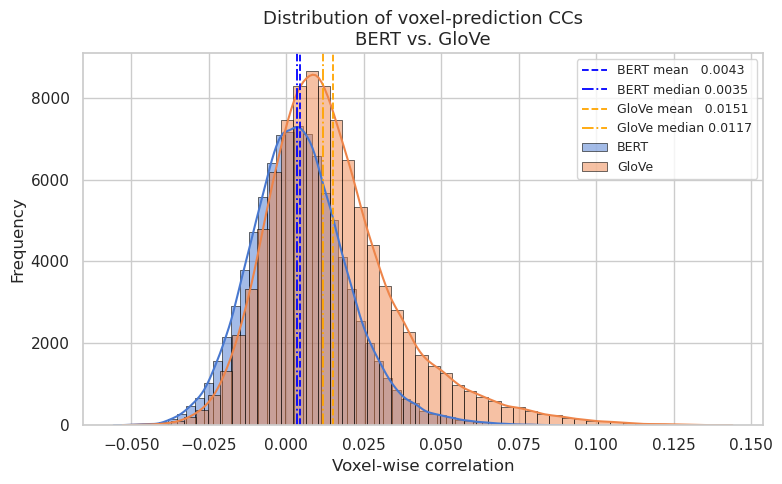

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("muted", 2)

bert  = np.clip(final_bert_corrs2 , -1, 1)
glove = np.clip(final_glove_corrs, -1, 1)

bert  = bert [~np.isnan(bert )]
glove = glove[~np.isnan(glove)]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5))

sns.histplot(bert ,  bins=50, kde=True, color=palette[0],
             edgecolor='black', linewidth=0.4, alpha=0.50, label="BERT")

sns.histplot(glove, bins=50, kde=True, color = palette[1],
             edgecolor='black', linewidth=0.4, alpha=0.50, label="GloVe")

def draw_line(value, colour, style, text):
    plt.axvline(value, color=colour, linestyle=style, linewidth=1.3, label=text)

draw_line(bert.mean() , 'blue' , '--', f'BERT mean   {bert.mean():.4f}')
draw_line(np.median(bert) , 'blue' , '-.' , f'BERT median {np.median(bert):.4f}')

draw_line(glove.mean(), 'orange', '--', f'GloVe mean   {glove.mean():.4f}')
draw_line(np.median(glove), 'orange', '-.', f'GloVe median {np.median(glove):.4f}')

plt.xlabel('Voxel-wise correlation', fontsize=12)
plt.ylabel('Frequency',            fontsize=12)
plt.title('Distribution of voxel-prediction CCs\nBERT vs. GloVe', fontsize=13)
plt.legend(frameon=True, fontsize=9)
plt.tight_layout()

# Save
plt.savefig('corr_hist_BERT_vs_GloVe.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
def predict_each_story(test_story,
                       valphas,
                       embeddings_dict,
                       respond_dict, 
                       respond_dict_test,   
                       train_story_list,
                       N_SPLITS=5,
                       RANDOM_STATE=42,
                       logger=logging.getLogger("ridge"),
                       candidate_alphas=None):
    """
    Train voxel-wise ridge on *train_story_list* and evaluate on a single held-out story.
    
    embeddings_dict:  dict {story : 2-D design matrix   [T, F]}
    respond_dict:     dict {story : 2-D BOLD matrix     [T, V]}  (training)
    respond_dict_test:dict {story : 2-D BOLD matrix     [T, V]}  (test)
    valphas:          per-voxel ridge penalties chosen from outer CV  [V]
    """
    
    Rstim_train = np.vstack([embeddings_dict[k] for k in train_story_list])   # [Ttrain, F]
    Rresp_train = np.vstack([respond_dict[k]   for k in train_story_list])    # [Ttrain, V]


    stim_mean = Rstim_train.mean(0, keepdims=True)
    stim_std  = Rstim_train.std (0, keepdims=True)
    stim_std  = np.where(stim_std == 0, 1e-8, stim_std)   # avoid /0

    Rstim_train = (Rstim_train - stim_mean) / stim_std
    Rresp_train = zs(Rresp_train)

    Pstim_test = embeddings_dict[test_story]
    Presp_test = respond_dict_test[test_story]

    Pstim_test = (Pstim_test - stim_mean) / stim_std

    test_corrs = ridge_corr_pred(
        Rstim = Rstim_train,
        Pstim = Pstim_test,
        Rresp = Rresp_train,
        Presp = Presp_test,
        valphas = valphas,
        normalpha = True,
        use_corr  = True,
        singcutoff=1e-8,
        logger = logger
    )

    valid = test_corrs[~np.isnan(test_corrs)]
    logger.info(f"--- Test story: {test_story} ---")
    logger.info(f"Mean CC    : {valid.mean():.4f}")
    logger.info(f"Median CC  : {np.median(valid):.4f}")
    logger.info(f"Top 1% CC  : {np.percentile(valid, 99):.4f}")
    logger.info(f"Top 5% CC  : {np.percentile(valid, 95):.4f}")
    logger.info(f"Using {len(valid)}/{len(test_corrs)} voxels (non-NaN)")

    return test_corrs

In [ ]:
## Results per story for subject 2 using BERT (For figure in report, will append this to figure from 3.1)

valphas = np.load("results/valphas_bert2.npy")

for story in val_test_stories:
    test_corrs = predict_each_story(
        test_story        = story,
        valphas           = valphas,
        embeddings_dict   = X_bert,
        respond_dict      = respond_dict2, 
        respond_dict_test = respond_dict_test2,
        train_story_list  = val_train_stories
    )
    np.save(f"corrs_{story}3.npy", test_corrs)

In [ ]:
## Results per story for subject 2 using BERT

for story in val_test_stories:
    test_corrs = np.load(f"results/corrs_{story}2.npy")
    valid_corrs = test_corrs[~np.isnan(test_corrs)]
    if len(valid_corrs) == 0:
         logger.warning("All final test correlations are NaN.")
    else:
        mean_cc = np.mean(valid_corrs)
        median_cc = np.median(valid_corrs)
        top_1_percentile_cc = np.percentile(valid_corrs, 99)
        top_5_percentile_cc = np.percentile(valid_corrs, 95)
        
        print(f"Test story name: {story}")
        print(f"Mean Test CC: {mean_cc:.4f}")
        print(f"Median Test CC: {median_cc:.4f}")
        # print(f"Top 1 Percentile Test CC: {top_1_percentile_cc:.4f}")
        # print(f"Top 5 Percentile Test CC: {top_5_percentile_cc:.4f}")
    

In [ ]:
## Results per story for subject 2 in a table

story_results = []

for story in val_test_stories:
    test_corrs = np.load(f"results/corrs_{story}2.npy")
    valid_corrs = test_corrs[~np.isnan(test_corrs)]

    mean_cc = np.nan
    median_cc = np.nan
    top_1_percentile_cc = np.nan
    top_5_percentile_cc = np.nan

    if len(valid_corrs) == 0:
         logger.warning(f"All final test correlations are NaN for story: {story}.")
    else:
        mean_cc = np.mean(valid_corrs)
        median_cc = np.median(valid_corrs)
        # Ensure there's enough data for percentile calculation, though np.percentile handles small arrays
        top_1_percentile_cc = np.percentile(valid_corrs, 99)
        top_5_percentile_cc = np.percentile(valid_corrs, 95)

    story_results.append({
        "Story Name": story,
        "Mean CC": mean_cc,
        "Median CC": median_cc,
        "Top 1% CC": top_1_percentile_cc,
        "Top 5% CC": top_5_percentile_cc
    })

results_df = pd.DataFrame(story_results)
sorted_df = results_df.sort_values(by="Mean CC", ascending=False, na_position='last')

print(sorted_df.to_string(index=False, float_format="%.4f"))

In [26]:
## Results per story for subject 3 using BERT (For figure in report, will append this to figure from 3.1)

valphas = np.load("results/valphas_bert3.npy")

for story in val_test_stories:
    test_corrs = predict_each_story(
        test_story        = story,
        valphas           = valphas,
        embeddings_dict   = X_bert,        
        respond_dict      = respond_dict3, 
        respond_dict_test = respond_dict_test3,
        train_story_list  = val_train_stories
    )
    np.save(f"results/corrs_{story}3.npy", test_corrs)

2025-04-25 19:22:14,914 - INFO - Doing SVD...
2025-04-25 19:22:15,258 - INFO - Dropped 0 tiny singular values.. (U is now (28644, 512))
2025-04-25 19:22:15,259 - INFO - Training stimulus has LSV norm: 591.259
2025-04-25 19:22:19,010 - INFO - Average difference between actual & assumed Prespvar: 0.000
2025-04-25 19:22:19,822 - INFO - --- Test story: thesecrettomarriage ---
2025-04-25 19:22:19,823 - INFO - Mean CC    : 0.0071
2025-04-25 19:22:19,826 - INFO - Median CC  : 0.0070
2025-04-25 19:22:19,828 - INFO - Top 1% CC  : 0.1623
2025-04-25 19:22:19,830 - INFO - Top 5% CC  : 0.1153
2025-04-25 19:22:19,830 - INFO - Using 95556/95556 voxels (non-NaN)
2025-04-25 19:22:51,980 - INFO - Doing SVD...
2025-04-25 19:22:52,331 - INFO - Dropped 0 tiny singular values.. (U is now (28644, 512))
2025-04-25 19:22:52,332 - INFO - Training stimulus has LSV norm: 591.259
2025-04-25 19:22:56,041 - INFO - Average difference between actual & assumed Prespvar: 0.000
2025-04-25 19:22:56,948 - INFO - --- Test s

In [27]:
## Results per story for subject 3 using BERT

for story in val_test_stories:
    test_corrs = np.load(f"results/corrs_{story}3.npy")
    valid_corrs = test_corrs[~np.isnan(test_corrs)]
    if len(valid_corrs) == 0:
         logger.warning("All final test correlations are NaN.")
    else:
        mean_cc = np.mean(valid_corrs)
        median_cc = np.median(valid_corrs)
        top_1_percentile_cc = np.percentile(valid_corrs, 99)
        top_5_percentile_cc = np.percentile(valid_corrs, 95)
        
        print(f"Test story name: {story}")
        print(f"Mean Test CC: {mean_cc:.4f}")
        print(f"Median Test CC: {median_cc:.4f}")
        # print(f"Top 1 Percentile Test CC: {top_1_percentile_cc:.4f}")
        # print(f"Top 5 Percentile Test CC: {top_5_percentile_cc:.4f}")
    

Test story name: thesecrettomarriage
Mean Test CC: 0.0071
Median Test CC: 0.0070
Test story name: beneaththemushroomcloud
Mean Test CC: 0.0145
Median Test CC: 0.0124
Test story name: lawsthatchokecreativity
Mean Test CC: 0.0081
Median Test CC: 0.0065
Test story name: escapingfromadirediagnosis
Mean Test CC: -0.0018
Median Test CC: -0.0017
Test story name: undertheinfluence
Mean Test CC: 0.0062
Median Test CC: 0.0065
Test story name: avatar
Mean Test CC: 0.0077
Median Test CC: 0.0073
Test story name: whenmothersbullyback
Mean Test CC: -0.0006
Median Test CC: -0.0007
Test story name: wildwomenanddancingqueens
Mean Test CC: 0.0112
Median Test CC: 0.0110
Test story name: googlingstrangersandkentuckybluegrass
Mean Test CC: 0.0110
Median Test CC: 0.0101
Test story name: christmas1940
Mean Test CC: 0.0270
Median Test CC: 0.0238
Test story name: sweetaspie
Mean Test CC: 0.0081
Median Test CC: 0.0077
Test story name: birthofanation
Mean Test CC: 0.0181
Median Test CC: 0.0166
Test story name: te

In [28]:
## Results per story for subject 3 in a table

story_results = []

for story in val_test_stories:
    test_corrs = np.load(f"results/corrs_{story}3.npy")
    valid_corrs = test_corrs[~np.isnan(test_corrs)]

    mean_cc = np.nan
    median_cc = np.nan
    top_1_percentile_cc = np.nan
    top_5_percentile_cc = np.nan

    if len(valid_corrs) == 0:
         logger.warning(f"All final test correlations are NaN for story: {story}.")
    else:
        mean_cc = np.mean(valid_corrs)
        median_cc = np.median(valid_corrs)
        # Ensure there's enough data for percentile calculation, though np.percentile handles small arrays
        top_1_percentile_cc = np.percentile(valid_corrs, 99)
        top_5_percentile_cc = np.percentile(valid_corrs, 95)

    story_results.append({
        "Story Name": story,
        "Mean CC": mean_cc,
        "Median CC": median_cc,
        "Top 1% CC": top_1_percentile_cc,
        "Top 5% CC": top_5_percentile_cc
    })

results_df = pd.DataFrame(story_results)
sorted_df = results_df.sort_values(by="Mean CC", ascending=False, na_position='last')

print(sorted_df.to_string(index=False, float_format="%.4f"))

                           Story Name  Mean CC  Median CC  Top 1% CC  Top 5% CC
                        christmas1940   0.0270     0.0238     0.2267     0.1609
                       birthofanation   0.0181     0.0166     0.1940     0.1387
              beneaththemushroomcloud   0.0145     0.0124     0.1863     0.1256
                                 life   0.0133     0.0122     0.1450     0.1037
            wildwomenanddancingqueens   0.0112     0.0110     0.2107     0.1499
googlingstrangersandkentuckybluegrass   0.0110     0.0101     0.1477     0.1030
                                souls   0.0105     0.0095     0.1566     0.1095
                thepostmanalwayscalls   0.0100     0.0082     0.1570     0.1065
                           sweetaspie   0.0081     0.0077     0.2261     0.1608
              lawsthatchokecreativity   0.0081     0.0065     0.1501     0.1032
                               avatar   0.0077     0.0073     0.1515     0.1060
                  thesecrettomarriage   

In [13]:
## Plotting correlation distributions for our best performing and worst performing stories for subject 2

import seaborn as sns

story1_corrs = np.load("results/corrs_wildwomenanddancingqueens.npy")
story2_corrs = np.load("results/corrs_life.npy")
data_loaded = True
story1_label = "Wild Women & Dancing Queens"
story2_label = "Life"

df1 = pd.DataFrame({'Correlation': story1_corrs, 'Story': story1_label})
df2 = pd.DataFrame({'Correlation': story2_corrs, 'Story': story2_label})
combined_df = pd.concat([df1, df2], ignore_index=True)

sns.set_theme(style="whitegrid", palette="muted")

plt.figure(figsize=(10, 6)) 

ax = sns.histplot(
    data=combined_df,
    x='Correlation',
    hue='Story',        
    bins=50,            
    kde=True,
    alpha=0.6,  
    edgecolor='black', 
    linewidth=0.3,
    stat='frequency'
)

palette = sns.color_palette("muted", 2)

valid_corrs = story1_corrs[~np.isnan(story1_corrs)]
mean1= np.mean(valid_corrs)
median1 = np.median(valid_corrs)
ax.axvline(mean1, color=palette[0], linestyle='--', linewidth=1.5, label=f'{story1_label} Mean: {mean1:.4f}')


valid_corrs = story2_corrs[~np.isnan(story2_corrs)]
mean2= np.mean(valid_corrs)
median2 = np.median(valid_corrs)
ax.axvline(mean2, color=palette[1], linestyle='--', linewidth=1.5, label=f'{story2_label} Mean: {mean2:.4f}')


handles, labels = ax.get_legend_handles_labels()

num_stories = combined_df['Story'].nunique()
story_handles = handles[:num_stories*2]
story_labels = labels[:num_stories*2]

vline_handles = handles[num_stories*2:]
vline_labels = labels[num_stories*2:]

ax.legend(handles=vline_handles, labels=vline_labels, title='Statistics', loc='upper right')



plt.xlabel('Correlation Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Correlatioins for Two Stories', fontsize=14)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.tight_layout()

# save_filename = 'last_fig.png'
# plt.savefig(save_filename, dpi=300, bbox_inches='tight')
# print(f"Plot saved as {save_filename}")

plt.show()

NameError: name 'sns' is not defined

In [ ]:
## Plotting correlation distributions for our best performing and worst performing stories for subject 2

import seaborn as sns

story1_corrs = np.load("corrs_sweetaspie.npy")
story2_corrs = np.load("corrs_googlingstrangersandkentuckybluegrass.npy")
data_loaded = True
story1_label = "Wild Women & Dancing Queens"
story2_label = "Life"

df1 = pd.DataFrame({'Correlation': story1_corrs, 'Story': story1_label})
df2 = pd.DataFrame({'Correlation': story2_corrs, 'Story': story2_label})
combined_df = pd.concat([df1, df2], ignore_index=True)

sns.set_theme(style="whitegrid", palette="muted")

plt.figure(figsize=(10, 6)) 

ax = sns.histplot(
    data=combined_df,
    x='Correlation',
    hue='Story',        
    bins=50,            
    kde=True,
    alpha=0.6,  
    edgecolor='black', 
    linewidth=0.3,
    stat='frequency'
)

palette = sns.color_palette("muted", 2)

valid_corrs = story1_corrs[~np.isnan(story1_corrs)]
mean1= np.mean(valid_corrs)
median1 = np.median(valid_corrs)
ax.axvline(mean1, color=palette[0], linestyle='--', linewidth=1.5, label=f'{story1_label} Mean: {mean1:.4f}')


valid_corrs = story2_corrs[~np.isnan(story2_corrs)]
mean2= np.mean(valid_corrs)
median2 = np.median(valid_corrs)
ax.axvline(mean2, color=palette[1], linestyle='--', linewidth=1.5, label=f'{story2_label} Mean: {mean2:.4f}')


handles, labels = ax.get_legend_handles_labels()

num_stories = combined_df['Story'].nunique()
story_handles = handles[:num_stories*2]
story_labels = labels[:num_stories*2]

vline_handles = handles[num_stories*2:]
vline_labels = labels[num_stories*2:]

ax.legend(handles=vline_handles, labels=vline_labels, title='Statistics', loc='upper right')



plt.xlabel('Correlation Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Correlatioins for Two Stories', fontsize=14)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.tight_layout()

# save_filename = 'last_fig.png'
# plt.savefig(save_filename, dpi=300, bbox_inches='tight')
# print(f"Plot saved as {save_filename}")

plt.show()

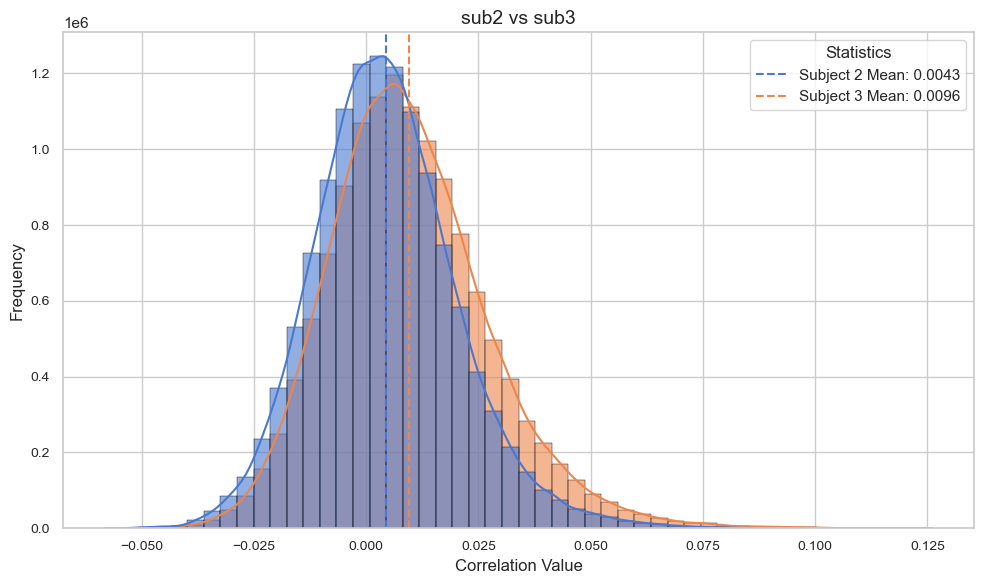

In [5]:
import seaborn as sns

story1_corrs = final_bert_corrs2
story2_corrs = final_bert_corrs3
data_loaded = True
story1_label = "Subject 2"
story2_label = "Subject 3"

df1 = pd.DataFrame({'Correlation': story1_corrs, 'Story': story1_label})
df2 = pd.DataFrame({'Correlation': story2_corrs, 'Story': story2_label})
combined_df = pd.concat([df1, df2], ignore_index=True)

sns.set_theme(style="whitegrid", palette="muted")

plt.figure(figsize=(10, 6)) 


ax = sns.histplot(
    data=combined_df,
    x='Correlation',
    hue='Story',        
    bins=50,            
    kde=True,
    alpha=0.6,  
    edgecolor='black', 
    linewidth=0.3,
    stat='frequency'
)

palette = sns.color_palette("muted", 2) # Get the first 2 colors from the palette

valid_corrs = story1_corrs[~np.isnan(story1_corrs)]
mean1= np.mean(valid_corrs)
median1 = np.median(valid_corrs)
ax.axvline(mean1, color=palette[0], linestyle='--', linewidth=1.5, label=f'{story1_label} Mean: {mean1:.4f}')
# ax.axvline(median1, color=palette[0], linestyle='-.', linewidth=1.5, label=f'{story1_label} Median: {median1:.2f}')


valid_corrs = story2_corrs[~np.isnan(story2_corrs)]
mean2= np.mean(valid_corrs)
median2 = np.median(valid_corrs)
ax.axvline(mean2, color=palette[1], linestyle='--', linewidth=1.5, label=f'{story2_label} Mean: {mean2:.4f}')
# ax.axvline(median2, color=palette[1], linestyle='-.', linewidth=1.5, label=f'{story2_label} Median: {median2:.2f}')


handles, labels = ax.get_legend_handles_labels()

num_stories = combined_df['Story'].nunique()
story_handles = handles[:num_stories*2]
story_labels = labels[:num_stories*2]

vline_handles = handles[num_stories*2:]
vline_labels = labels[num_stories*2:]

ax.legend(handles=vline_handles, labels=vline_labels, title='Statistics', loc='upper right')



plt.xlabel('Correlation Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('sub2 vs sub3', fontsize=14)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


plt.tight_layout()

# save_filename = 'last_fig.png'
plt.savefig('comparing_both_subjects.png', dpi=300, bbox_inches='tight')
# print(f"Plot saved as {save_filename}")

plt.show()